### A Sticky HMM implementation for continuous state visualization

#### The HMM model is used to model the dynamics of a sequence of time consecutive data. For trading purposes it can be used to give signals to guide transactions. But in the original framework, it is very easy to get noisy states as they tend to transit quickly between each other, thus giving quick buy and sell signals. In this project, we try to impose consitions on the trained HMM model so that slef-transition probablities in the HMM model is being pumped up to a minimum threshold to support more continuous state signals. A score function is developed to capture the quality of the trained model and resulting visualization on the time series data. The score function sums up the hypothetical long and short profits from following the state signals while subtracting the missing profits due to oscillation and the transaction penalty fees incurred from every trades.

The data consist of today's return, today's close, and today's volume. The volume data is processed to be taken to log scale.

In [19]:
import numpy as np
X = np.load('zipped_X2.npy')
Vols = X[:-3,-1].copy()
#X

In [20]:
X[:,-1] = X[:,-1]/1000.0
X[:,-1]=np.log(X[:,-1]+1e-6)/1000
#X

Features include past 5 days sum of return, past 5 days price range, and past 5 days sum volume(log scaled).

In [21]:
XX=[]
w = 5
for i in range(int(len(X)/w)):
    #x = list(X[i*w:w*i+w,0])
    x=[sum(X[i*w:i*w+w,0])*1.0]
    x+=[(max(X[i*w:i*w+w,1])-min(X[i*w:i*w+w,1]))]
    x+=[sum(X[i*w:i*w+w,-1])*1.0]
    XX.append(x)
#XX

In [22]:
Mins = np.load('Mins.npy')
Mins = Mins[:-3]

In [23]:
Close = np.load('close.npy')
Close=Close[:-3]

We first train a normal HMM model with a given number of states, the emissions are assumed to by gaussian based on observations of the data.


In [24]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from hmmlearn import hmm
warnings.filterwarnings('ignore')
np.random.seed(10)
model = hmm.GaussianHMM(n_components=8, covariance_type="full", min_covar=0.0,verbose=True,n_iter=100)
model.fit(XX)  
model.monitor_  

         1      172073.2923             +nan
         2      147099.7291      -24973.5633


ConvergenceMonitor(history=[172073.29232932586, 147099.72907770387], iter=2,
          n_iter=100, tol=0.01, verbose=True)

The resulting transition matrix looks like:

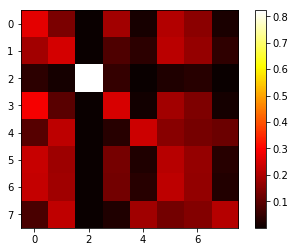

In [8]:
from matplotlib import pyplot as plt
from matplotlib.colors import PowerNorm

%matplotlib inline
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

We use the maximum of maximum transition probability from each state and a fixed threshold to lower bound the state's self-transition probability. 

A lower fixed bound results in more dynamic state transitions while a high threshold results in more discrete state segments.

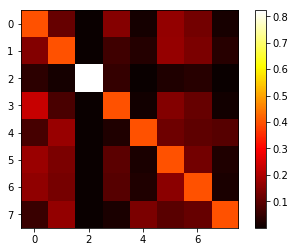

In [9]:

#p = 0.7
for s in range(model.n_components):
    p = max(0.4,np.max(model.transmat_[s]))
    if model.transmat_[s][s]>=p:
        pass
    else:
        denom = sum(model.transmat_[s])-model.transmat_[s][s]
        model.transmat_[s]/=denom
        model.transmat_[s]*=1-p
        model.transmat_[s][s] = p
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

We further induce self-transition by squaring each row of the transition matrix and normalize.

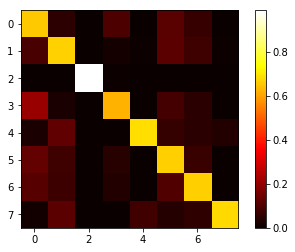

In [10]:
for s in range(model.n_components):
    model.transmat_[s] = model.transmat_[s]**2
    model.transmat_[s]/=sum(model.transmat_[s])
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

The resulting state transitions:

In [11]:
ZZ = model.predict(XX)

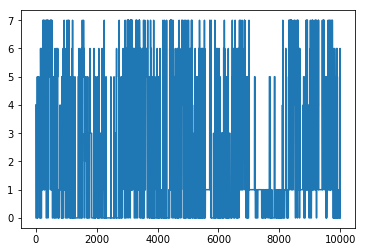

In [12]:
plt.plot(ZZ)

In [13]:
len(XX),len(ZZ)

(9999, 9999)

In [14]:
len(Mins),len(Close)

(49995, 49995)

In [15]:
Z=[]
for i in ZZ:
    Z+=[i]*w
print len(Z)
Z = np.array(Z)

49995


In [16]:

print("Transition matrix")
print(model.transmat_)
print()
from matplotlib import cm
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()



Transition matrix
[[6.59572418e-01 5.35063752e-02 8.49898258e-08 9.72215761e-02
  9.79933534e-04 1.18007477e-01 6.93735580e-02 1.33857715e-03]
 [9.48289951e-02 6.71518015e-01 2.41230284e-09 1.88310693e-02
  5.18811510e-03 1.23546889e-01 8.00874496e-02 5.99946435e-03]
 [2.70703453e-03 3.52968791e-04 9.89555685e-01 4.11985870e-03
  3.94004191e-07 1.10570002e-03 2.15835833e-03 7.51092293e-10]
 [2.11888599e-01 2.42142829e-02 2.05505093e-05 6.24787668e-01
  3.79743367e-04 8.78660589e-02 5.02071610e-02 6.35936240e-04]
 [2.44176411e-02 1.30202577e-01 2.65216360e-11 3.53596463e-03
  6.90485268e-01 6.52187562e-02 4.76167839e-02 3.85230090e-02]
 [1.32063215e-01 7.99524357e-02 1.72107522e-08 4.35634755e-02
  1.91937463e-03 6.67006536e-01 7.21808880e-02 3.31405798e-03]
 [1.14124859e-01 7.41300421e-02 7.16524301e-09 3.69227092e-02
  2.86668952e-03 1.05174927e-01 6.64933965e-01 1.84680074e-03]
 [1.50131388e-02 1.21954803e-01 2.52705465e-07 1.81984901e-03
  8.24149692e-02 4.13216520e-02 5.48001342e-0

The score function is used to evaluate this state mapping by ways of virtually trading the asset based on current state mappings.

States are grouped into rise/fall/oscillate classes based on end returns. In each class, each state contributes to the total trading
profit by adding the end gross return and substracting the trading fees, also serving as a penalty function for discontinuity in states,
associated with every change of state segments in each state.

In [17]:
Ret = X[:,0]
log_Ret = np.log(Ret+1.0)
def score_plot(Mins,Close,Vols,Ret,Z,n_comp,fee=0.005):
    end = []
    Seg = []
    plt.figure()
    for i in range(n_comp):
        cur = [0]
        seg = 0
        flag= False
        for j in range(len(Z)):
            if i == Z[j]:
                if not flag:
                    seg+=1
                    flag = True
                cur.append(cur[-1]+Ret[j])
            else:
                if flag:
                    flag=False
                cur.append(cur[-1])
        end.append(cur[-1])
        Seg.append(seg)
        plt.plot(Mins,cur[1:],label='Z='+str(i)+' '+str(cur[-1]))
    plt.legend(loc='upper left')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Log Return')
    plt.figure()
    fig, ax1 = plt.subplots(figsize=(20,6))
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('eth-btc', color=color)
    ax1.plot(Mins, Close, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
    ax2.plot(Mins, Vols, color=color)
    ax2.set_ylim(0,1000)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout() 
    score_up = 0
    score_down = 0
    score_none = 0
    tseg = sum(Seg)
    #fee=0.005
    for i in range(n_comp):

        if end[i]<0.5*max(end) and end[i]>0.5*min(end):
            score_none+=end[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'bo',markersize=1)
        elif end[i]>=0.5*max(end):
            score_up+=end[i]-fee*Seg[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'ro',markersize=3)
        else:
            score_down+=abs(end[i])-fee*Seg[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'go',markersize=3)
    score = score_up+score_down-abs(score_none)
    print 'Score:'+str(score)
    return score,Seg

Score:0.977399871501462


(0.977399871501462, [182, 142, 5, 31, 87, 169, 120, 125])

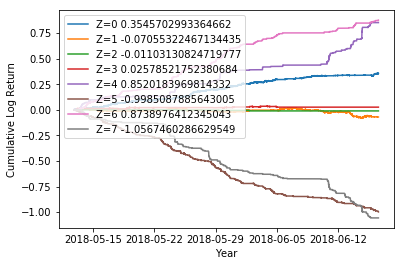

<Figure size 432x288 with 0 Axes>

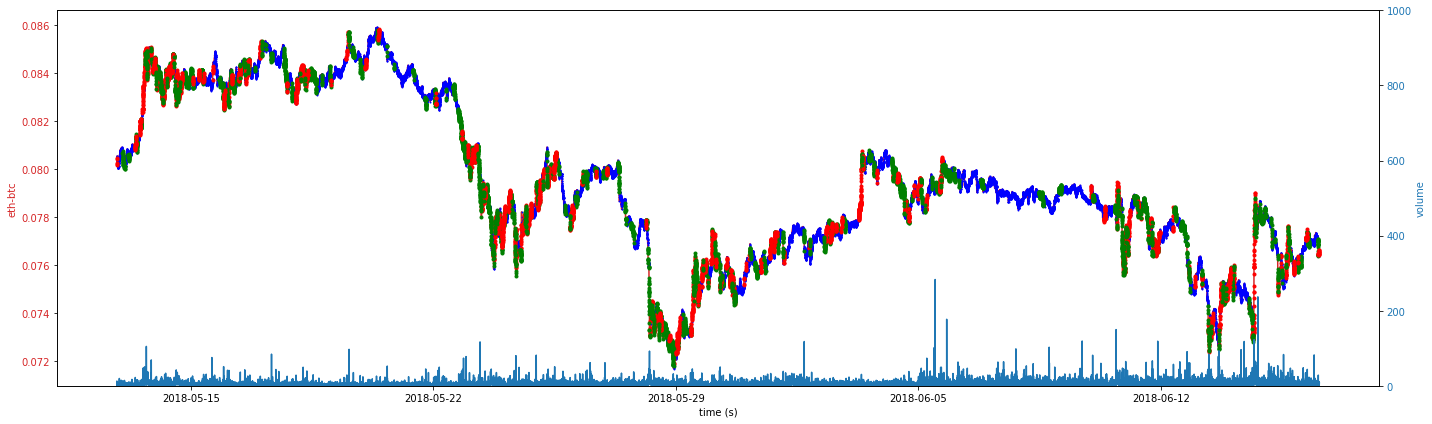

In [18]:
score_plot(Mins,Close,Vols,Ret,Z,model.n_components,fee=0.005)

### Results:
#### p threshold = 0.9:  Score = 0.973
####            = 0.7:  Score = 1.048
####            = 0.5:  Score = 1.192
####            = 0.4:  Score = 0.977
####            = 0.3:  Score = 0.099